In [3]:
import pathlib
import configparser
import os
import glob
import numpy as np
import pyvista as pv
import pandas as pd
import h5py
from svd_dataset import SVD
import tensorflow as tf


class CaseConfigParser(configparser.ConfigParser):
    def optionxform(self, optionstr):
        return optionstr

def clear_vtm(solution_file, output_file):
    multiblock = pv.read(solution_file)
    for i in range(len(multiblock)):
        for j in range(len(multiblock[i])):
            for k in range(len(multiblock[i][j])):
                multiblock[i][j][k].clear_point_data()
    multiblock.save(output_file)

    return pv.read(output_file)

def read_config_file(config_file):
    config = CaseConfigParser()
    config.read(config_file)

    # convert all path to the absolute
    for each_section in config.sections():
        for (each_key, each_val) in config.items(each_section):
            value = pathlib.Path(config[each_section][each_key])
            if value.is_file() or value.is_dir():
                config[each_section][each_key] = f"{value.resolve()}"
    return config


def get_converged_solutions(root_path, solution_path):
    solutions_id = []
    n_directories = len(
        list(filter(os.path.isdir, glob.glob(f'{root_path}/*'))))
    for i in range(n_directories):
        solution_file = f'{root_path}/{i+1}/{solution_path}'
        if len(list(glob.glob(f'{solution_file}*'))) > 0:
            solutions_id.append(i+1)

    return solutions_id


def sliceDataAlongAxis(data, fractions, axis):
    data_size = data.shape[axis]
    fractions_ = np.zeros_like(fractions, dtype=int)

    total_size = 0
    for i, fraction in enumerate(fractions):
        total_size += int(data_size*fraction)
    remain = data_size-total_size

    slices = ()
    for i, fraction in enumerate(fractions):
        fractions_[i] = int(data_size*fraction)
        if i > 0:
            fractions_[i] += fractions_[i-1]
            slice = data.take(range(fractions_[i-1], fractions_[i]), axis)

        else:
            slice = data.take(range(0, fractions_[i]+remain), axis)

        slices += (slice,)

    return slices

class NeuralNetwork:
    def __init__(self):
        
        self.name = 'neural_network'
  
    def set_model (self, 
        layers, 
        activation_function = 'tanh', 
        optimizer = tf.keras.optimizers.Adam(), 
        hidden_layers = None):

        self.nn = self.get_model(layers, activation_function, optimizer) 

    def get_model ( self, layers, activation_function, optimizer ):
        # Input layer
        ph_input = tf.keras.Input( shape =( layers[0] ,) ,name='input_placeholder')
        # Hidden layers
        hidden_layer = ph_input
        for num_neurons in layers[1:-1]:
            hidden_layer = tf.keras.layers.Dense ( num_neurons , activation = activation_function)( hidden_layer )

        # Output layer
        output = tf.keras.layers.Dense ( layers[-1] , activation ='linear',name='output_value')( hidden_layer)

        model = tf.keras.Model ( inputs =[ ph_input ], outputs =[ output ])
        # Compilation
        model.compile ( optimizer = optimizer , loss ={ 'output_value': 'mean_squared_error'})

        return model
    
    def fit(self, 
        train_input, 
        train_target, 
        validation_input=None, 
        validation_target=None, 
        epochs=1000, 
        batch_size=16  ):
        
        if validation_input is not None and validation_target is not None:       
            validation_tuple = (validation_input, validation_target)

        self.history = self.nn.fit(train_input, train_target, epochs=epochs, batch_size=batch_size, validation_data=validation_tuple)

        return self.nn, self.history
    
    def predict(self, input):
        if len(input.shape)==1:
            input = input[None,:]
        return self.nn.predict(input)
    
    def save(self, file):
        self.nn.save(file)

    def load(self, file):
        self.nn = tf.keras.models.load_model( file )


class dataHandler:
    def __init__(self, file, variables):
        self.file = file
        self.variables = variables
        self.stack()

    def stack(self):
        with h5py.File(self.file, 'r') as f:
            self.h5 = f
            self.data = np.vstack([f[var][()] for var in self.variables])

            self.indexes = {}
            start_idx = 0
            for var in self.variables:
                try:
                    end_idx = start_idx + f[var][()].shape[0]
                except:
                    # f[var] is a scalar
                    end_idx = start_idx + 1
                self.indexes[var] = np.arange(start_idx, end_idx)
                start_idx = end_idx

            if 'meshfile' in f.keys():
                self.meshfile = f['meshfile'][()]

    def get_variable(self, variable=None, data=None,):
        if data is None:
            data = self.data

        return data[self.indexes[variable], :]

    def split_train_validation_test(self, fractions):
        self.train, self.validation, self.test = sliceDataAlongAxis(
            self.data, fractions, 1)


class ROM:
    def __init__(self, dataset, rank=None):

        self.svd = SVD(dataset)

        self.bounds = [0, 1]

        self.svd.normalize(bounds=self.bounds)
        self.svd.subtractMean()
        self.svd.SVD()
        self.setRank(rank)

    def setRank(self, rank):
        self.rank = rank
        self.svd.setRank(self.rank)

    def setEnergy(self, e):
        self.energyPreserved = e
        self.rank = self.svd.findRank(self.energyPreserved)
        self.svd.setRank(self.rank)

    def reduce(self, snapshot):
        if len(snapshot.shape)==1:
            snapshot = snapshot[:,None]
        snapshot, min, max = self.svd.normalize(
            snapshot, self.bounds, self.svd.min, self.svd.max)
        snapshot, mean = self.svd.subtractMean(snapshot, self.svd.mean)
        L = (self.svd.u.T @ snapshot).T
        return L

    @property
    def data(self):
        return self.svd.L

    @property
    def L(self):
        return self.svd.L

    def reconstruct(self, input):
        return self.svd.reconstruct(input)


class FlowReconstruction:
    def __init__(self):
        pass

    def set_config_file(self, config_file):
        self.config_file = pathlib.Path(config_file).absolute()
        self.config = read_config_file(self.config_file)
        self.dataset_root = pathlib.Path(
            self.config['DATASET']['DATASET_ROOT']).absolute()
        self.doe_file = self.dataset_root / pathlib.Path(self.config['DATASET']['DOEFILE'])

        self.LF_PARAMS = dict(self.config['LF_PARAMS'])
        self.HF_PARAMS = dict(self.config['HF_PARAMS'])

    def get_converged_solutions(self):
        self.converged_solutions_id = get_converged_solutions(
            self.dataset_root, self.hf_solution_file)

    def set_lf_solution_path(self, path):
        self.lf_solution_path = pathlib.Path(path)

    def set_hf_solution_path(self, path):
        self.hf_solution_path = pathlib.Path(path)

    def set_hf_solution_file(self, file):
        self.hf_solution_file = pathlib.Path(self.hf_solution_path / file)

    def set_lf_variable_getter(self, variable_getter, variables_dict):
        self.lf_variables_dict = variables_dict
        self.lf_variable_getter = variable_getter

    def get_lf_variable(self, variable, idx=None, solution_path=None):
        if solution_path is None and idx is not None:
            solution_path = self.dataset_root / \
                str(idx) / self.lf_solution_path
        else:
            solution_path = pathlib.Path(solution_path) / self.lf_solution_path
        return self.lf_variable_getter(self.lf_variables_dict, variable, solution_path)

    def get_lf_variables(self, solution_path=None):
        if solution_path is None:
            solution_path = self.lf_fom_rootfile

        snapshot = []
        for var, value in self.lf_design_variables.items():
            snapshot.append(value)
        for var in self.lf_variables_dict.keys():
            value = self.get_lf_variable(var, solution_path)
            snapshot.append(value)

        return np.hstack(snapshot)

    def get_hf_variables(self, solution_file=None):
        if solution_file is None:
            solution_file = self.hf_fom_

    def set_hf_variable_getter(self, variable_getter, variables_dict):
        self.hf_variables_dict = variables_dict
        self.hf_variable_getter = variable_getter

    def get_hf_variable(self, variable, idx=None, solution_file=None):
        if solution_file is None and idx is not None:
            solution_file = self.dataset_root / \
                str(idx) / self.hf_solution_file
        else:
            # inconsistent !
            solution_file = pathlib.Path(solution_file) / self.hf_solution_path

        return self.hf_variable_getter(self.hf_variables_dict, variable, solution_file)

    def get_hf_snapshot(self, idx=None, solution_file=None, include_design_variables=True):
        if solution_file is None and idx is not None:
            solution_file = self.dataset_root / \
                str(idx) / self.hf_solution_file

        snapshot = {}
        if include_design_variables == True:
            df = pd.read_csv(self.doe_file).set_index('ID')
            design_variables = df.keys()
        elif include_design_variables == False:
            design_variables = []
        else:
            design_variables = include_design_variables

        for var in design_variables:
            snapshot[var] = df[var][idx]

        for var in self.hf_variables_dict.keys():
            if idx is not None:
                snapshot[var] = self.get_hf_variable(var, idx)
            elif solution_file is not None:
                snapshot[var] = self.get_hf_variable(
                    variable=var, solution_file=solution_file)

        return snapshot

    def get_lf_snapshot(self, idx=None, solution_path=None, include_design_variables=True):
        if solution_path is None and idx is not None:
            solution_path = self.dataset_root / \
                str(idx) / self.lf_solution_path
        else:
            solution_path = pathlib.Path(solution_path) / self.lf_solution_path

        snapshot = {}
        if include_design_variables == True:
            df = pd.read_csv(self.doe_file).set_index('ID')
            design_variables = df.keys()
        elif include_design_variables == False:
            design_variables = []
        else:
            design_variables = include_design_variables

        for var in design_variables:
            snapshot[var] = df[var][idx]

        for var in self.lf_variables_dict.keys():
            if idx is not None:
                snapshot[var] = self.get_lf_variable(var, idx)
            elif solution_path is not None:
                snapshot[var] = self.get_lf_variable(
                    variable=var, solution_path=solution_path)

        return snapshot

    def get_lf_snapshots(self, include_design_variables=True):
        snapshots = []
        for id in self.converged_solutions_id:
            snapshot = self.get_lf_snapshot(
                idx=id, include_design_variables=True)
            snapshots.append(snapshot)
        self.lf_variables = snapshot.keys()
        return snapshots

    def get_hf_snapshots(self, include_design_variables=True):
        snapshots = []
        for id in self.converged_solutions_id:
            snapshot = self.get_hf_snapshot(
                idx=id, include_design_variables=True)
            snapshots.append(snapshot)
           
        self.hf_variables = snapshot.keys()
        return snapshots

    def gen_HDF5(self, snapshots, h5_filename):
        with h5py.File(h5_filename, 'w') as h5file:
            len(snapshots)
            for key in snapshots[0].keys():
                n_rows = snapshots[0][key].size
                h5file[key] = np.zeros((n_rows, len(snapshots)))

                for i, snap_i in enumerate(snapshots):
                    h5file[key][:, i] = snap_i[key]

    def gen_lf_HDF5(self, h5_filename):
        self.lf_h5file = self.dataset_root / h5_filename
        self.gen_HDF5(self.get_lf_snapshots(), self.lf_h5file)
    
    def gen_hf_HDF5(self, h5_filename):
        self.hf_h5file = self.dataset_root / h5_filename
        self.gen_HDF5(self.get_hf_snapshots(), self.hf_h5file)


    def set_lf_data_handler(self, train_validation_test_fractions):
        self.lf_data_handler = dataHandler(
            self.lf_h5file, self.lf_variables)
        self.lf_data_handler.split_train_validation_test(train_validation_test_fractions)

    def set_hf_data_handler(self, train_validation_test_fractions):
        self.hf_data_handler = dataHandler(
            self.hf_h5file, self.hf_variables)
        self.hf_data_handler.split_train_validation_test(train_validation_test_fractions)

    def set_lf_rom(self, rom, **rom_config):
        self.lf_rom_rank = rom_config['rank']
        self.lf_rom = rom(self.lf_data_handler.train, **rom_config)

    def set_hf_rom(self, rom, **rom_config):
        self.hf_rom_rank = rom_config['rank']
        self.hf_rom = rom(self.hf_data_handler.train, **rom_config)

    def set_lf_fom(self, lf_fom):
        self.lf_fom = lf_fom

    def set_hf_fom(self, hf_fom):
        self.hf_fom = hf_fom

    def run_lf_fom(self, rootfile, **other_params):
        self.lf_fom_rootfile = f"{pathlib.Path(self.dataset_root / rootfile)}/"
        print(self.LF_PARAMS)
        self.lf_design_variables = dict(other_params)
        self.lf_fom(rootfile=self.lf_fom_rootfile, **
                    self.LF_PARAMS, **other_params)

    def run_hf_fom(self, rootfile, **other_params):
        self.hf_fom_rootfile = f"{pathlib.Path(self.dataset_root / rootfile)}/"
        print(self.HF_PARAMS)
        self.hf_design_variables = dict(other_params)
        self.hf_fom(rootfile=self.hf_fom_rootfile, **
                    self.HF_PARAMS, **other_params)

    def reconstruct_snapshot(self):
        pass

    def reconstruct(self, rootfile, **other_params):
        self.run_lf_fom(rootfile, **other_params)
        self.run_hf_fom(rootfile, only_generate_mesh=True, **other_params)

        self.hf_reconstructed_file = self.hf_fom_rootfile / self.hf_solution_path / 'reconstructed.vtm'
        clear_vtm(self.hf_fom_rootfile / self.hf_solution_file, self.hf_reconstructed_file)

        lf_fom_solution = self.get_lf_variables(solution_path=self.lf_fom_rootfile)
        lf_projected = self.lf_rom.reduce(lf_fom_solution)
        hf_projected = self.surrogate.predict(lf_projected)
        hf_reconstructed = self.hf_rom.reconstruct(hf_projected)

        reconstructed_mesh = pv.read(self.hf_reconstructed_file)

        for variable, index in fr.hf_variables_dict.items():
            value = self.hf_data_handler.get_variable(variable=variable, data=hf_reconstructed)
            get_block_recursive(reconstructed_mesh, index[:-1])[variable] = value

        reconstructed_mesh.save(self.hf_reconstructed_file)
        
    def set_surrogate(self, surrogate, surrogate_config):
        self.surrogate = surrogate()
        if self.surrogate.name == 'neural_network':
            surrogate_config['layers'] = [self.lf_rom_rank] + surrogate_config['hidden_layers'] + [self.hf_rom_rank]

            self.surrogate.set_model(**surrogate_config)
    

def lf_variable_getter(variables_dict, variable, solution_path):
    solution_path = pathlib.Path(solution_path)
    return np.loadtxt(solution_path / variables_dict[variable])


def get_block_recursive(block, name_index):
    for n in name_index:
        block = block[n]
    return block


def hf_variable_gatter(variables_dict, variable, solution_file):
    block = pv.read(solution_file)
    return get_block_recursive(block, variables_dict[variable])


In [4]:
fr = FlowReconstruction()

fr.set_config_file('/home/ppiper/Dropbox/local/ihtc_repository/src/doe_60.cfg')
fr.set_lf_solution_path('./Q1D/outputs/')
fr.set_hf_solution_path('./SU2/outputs/')
fr.set_hf_solution_file('cht_setupSU2.vtm')
fr.get_converged_solutions()

fr.set_lf_variable_getter( lf_variable_getter, variables_dict={
    'Pressure' : 'p.txt',
    'Temperature' : 'T.txt',
    'Mach' : 'M.txt'
})

fr.set_hf_variable_getter( hf_variable_gatter, variables_dict={
    'Pressure' : 
        ['Zone 0 (Comp. Fluid)','Internal','Internal','Pressure'],
    'Temperature' :
        ['Zone 0 (Comp. Fluid)','Internal','Internal','Temperature'],
    'Mach' : 
        ['Zone 0 (Comp. Fluid)','Internal','Internal','Mach'] ,
    'Temperature_Solid' :
        ['Zone 1 (Solid Heat)', 'Internal', 'Internal', 'Temperature'] ,
    'Temperature_Solid_INNERWALL' : 
        ['Zone 1 (Solid Heat)', 'Boundary', 'INNERWALL', 'Temperature'] ,
    'Heat_Flux_UPPER_WALL' : 
        ['Zone 0 (Comp. Fluid)', 'Boundary','UPPER_WALL', 'Heat_Flux'] ,
})



In [5]:
fr.gen_lf_HDF5('lf.h5')

In [6]:
fr.gen_hf_HDF5('hf.h5')

In [7]:
fr.set_lf_data_handler(train_validation_test_fractions=[0.8,0.1,0.1])

In [8]:
fr.set_hf_data_handler(train_validation_test_fractions=[0.8,0.1,0.1])

In [9]:
fr.set_lf_rom(ROM, rank=5)

In [10]:
fr.set_hf_rom(ROM, rank=10)

In [11]:
fr.set_surrogate(surrogate = NeuralNetwork, 
                 surrogate_config=dict(
                    hidden_layers=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10], activation_function='tanh',
                    optimizer=tf.keras.optimizers.Adam())
)


fr.surrogate.fit(
              train_input= fr.lf_rom.data,
              train_target= fr.hf_rom.data,
              validation_input= fr.lf_rom.reduce(fr.lf_data_handler.validation),
              validation_target= fr.hf_rom.reduce(fr.hf_data_handler.validation),
              epochs=300)

Epoch 1/300
3/3 [==============================] - 2s 123ms/step - loss: 0.5899 - val_loss: 0.4513
Epoch 2/300
3/3 [==============================] - 0s 20ms/step - loss: 0.5790 - val_loss: 0.4431
Epoch 3/300
3/3 [==============================] - 0s 23ms/step - loss: 0.5676 - val_loss: 0.4326
Epoch 4/300
3/3 [==============================] - 0s 20ms/step - loss: 0.5506 - val_loss: 0.4200
Epoch 5/300
3/3 [==============================] - 0s 20ms/step - loss: 0.5334 - val_loss: 0.4039
Epoch 6/300
3/3 [==============================] - 0s 24ms/step - loss: 0.5103 - val_loss: 0.3862
Epoch 7/300
3/3 [==============================] - 0s 19ms/step - loss: 0.4836 - val_loss: 0.3656
Epoch 8/300
3/3 [==============================] - 0s 17ms/step - loss: 0.4560 - val_loss: 0.3444
Epoch 9/300
3/3 [==============================] - 0s 20ms/step - loss: 0.4255 - val_loss: 0.3237
Epoch 10/300
3/3 [==============================] - 0s 19ms/step - loss: 0.3980 - val_loss: 0.3035
Epoch 11/300
3/3 [

(<keras.engine.functional.Functional at 0x7f667c1bf010>,
 <keras.callbacks.History at 0x7f6758710810>)

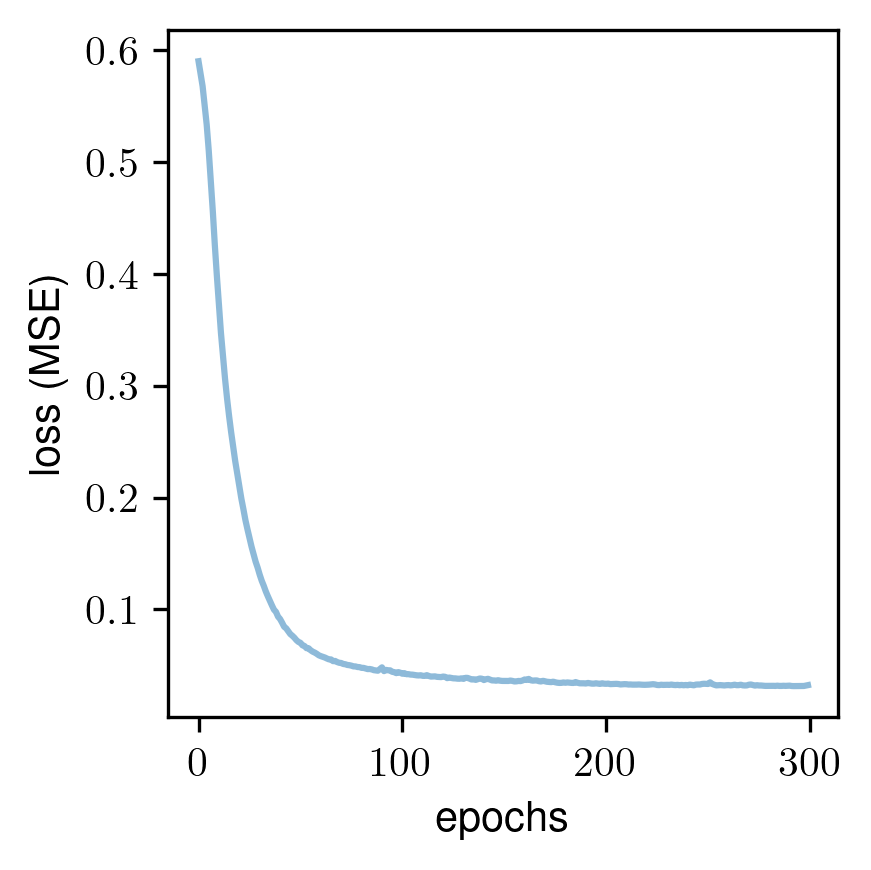

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['figure.dpi'] = 300

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(fr.surrogate.history.history['loss'], alpha=0.5)
plt.xlabel(r'epochs')
plt.ylabel(r'loss (MSE)')
plt.tight_layout()
plt.savefig('./figures/nn_training.pdf')
plt.show()

In [13]:
fr.surrogate.nn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_placeholder (InputLay  [(None, 5)]              0         
 er)                                                             
                                                                 
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                             

In [14]:
from models_parametric_shape import lf_model, hf_model

fr.set_lf_fom(lf_model)
fr.set_hf_fom(hf_model)

In [15]:
fr.reconstruct(rootfile='./flow_reconstruction_60', Thickness=0.004, CP3_y=0.0025)

{'Nx': '400', 'EULER_Q1D_SOLVER': '/home/ppiper/Dropbox/local/ihtc_repository/src/eulerQ1D', 'baselineCP': '/home/ppiper/Dropbox/local/ihtc_repository/src/baselineCP.txt', 'T0in': '600.0', 'p0in': '8.0e5'}
['/home/ppiper/Dropbox/local/ihtc_repository/src/eulerQ1D', '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/Q1D/inputs/setupQ1D.txt']
################################################################################
                           -*- Q1D Euler Solver -*-
Eigen 3.3.7
Allan Moreira de Carvalho
################################################################################
                           -*- Setup Information -*-
################################################################################
# Domain x-coordinates at cell faces (no need for ghost cells)
/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/Q1D/inputs/xn.txt
# Area distributuin at cell faces (no need for ghost cells)
/home/ppiper/Dropbox/loc

Info    : Done reading '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/SU2/inputs/solid_setupSU2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 20%] Meshing curve 2 (Extruded)
Info    : [ 30%] Meshing curve 3 (Extruded)
Info    : [ 40%] Meshing curve 4 (Extruded)
Info    : [ 50%] Meshing curve 5 (Nurb)
Info    : [ 70%] Meshing curve 6 (Extruded)
Info    : [ 80%] Meshing curve 7 (Extruded)
Info    : [ 90%] Meshing curve 8 (Extruded)
Info    : Done meshing 1D (Wall 0.00306433s, CPU 0.009103s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 50%] Meshing surface 9 (Extruded)
Info    : Done meshing 2D (Wall 0.43112s, CPU 0.560501s)
Info    : 48512 nodes 49146 elements
Info    : Writing '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/SU2/inputs/solid_setupSU2.su2'...
Info    : Writing 43890 elements and 44520 nodes
Info    : Done writing '/home/ppiper/Dropbox/loca

Info    : Done reading '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/SU2/inputs/solid_setupSU2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 20%] Meshing curve 2 (Extruded)
Info    : [ 30%] Meshing curve 3 (Extruded)
Info    : [ 40%] Meshing curve 4 (Extruded)
Info    : [ 50%] Meshing curve 5 (Nurb)
Info    : [ 70%] Meshing curve 6 (Extruded)
Info    : [ 80%] Meshing curve 7 (Extruded)
Info    : [ 90%] Meshing curve 8 (Extruded)
Info    : Done meshing 1D (Wall 0.00235549s, CPU 0.000508s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 5 (Extruded)
Info    : [ 50%] Meshing surface 9 (Extruded)
Info    : Done meshing 2D (Wall 0.386786s, CPU 0.462545s)
Info    : 48512 nodes 49146 elements
Info    : Writing '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/SU2/inputs/solid_setupSU2.msh'...
Info    : Done writing '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstructio

Info    : [ 50%] Meshing surface 9 (Extruded)
Info    : Done meshing 2D (Wall 0.377996s, CPU 0.5028s)
Info    : 48512 nodes 49146 elements
Info    : Writing '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/SU2/inputs/solid_setupSU2.vtk'...
Info    : Done writing '/home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/SU2/inputs/solid_setupSU2.vtk'
Info    : Stopped on Tue May  2 23:04:41 2023 (From start: Wall 0.592344s, CPU 0.811316s)
Input files:
1. setupSU2
2. solid_setupSU2
Multi-zone mesh written to file: /home/ppiper/Dropbox/local/ihtc_repository/data/doe_60/flow_reconstruction_60/SU2/inputs/multizone.su2

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.4.0 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Co

In [17]:
fr.lf_data_handler.train.shape

(1205, 48)

In [18]:
fr.hf_data_handler.data.shape[0]

252842

In [19]:
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.test)
hf_projected = fr.surrogate.predict(lf_projected)
hf_reconstructed= fr.hf_rom.reconstruct(hf_projected)

1/1 [==============================] - 0s 15ms/step


In [20]:
np.linalg.norm((hf_reconstructed-fr.hf_data_handler.test))

1571357.0977457704

In [21]:
(hf_reconstructed-fr.hf_data_handler.test)

array([[ 3.44607004e-03, -2.40025186e-03, -4.51339768e-04,
         3.76880553e-03, -2.60758315e-04, -1.84894375e-03],
       [ 2.31750902e-04,  5.24091261e-04,  3.04048165e-04,
         3.87262976e-04,  1.35959831e-04,  2.25318538e-05],
       [ 2.42860558e+03, -2.31535986e+03, -3.21402607e+02,
         5.20902051e+03, -1.56761502e+03, -1.70861540e+03],
       ...,
       [-3.57765737e+04,  2.44445383e+04,  5.12747129e+03,
        -4.94629965e+04,  9.59165726e+03,  2.24098161e+04],
       [-3.61889275e+04,  2.48494768e+04,  4.97277052e+03,
        -5.05333597e+04,  9.82096741e+03,  2.26031220e+04],
       [-3.66623963e+04,  2.52101360e+04,  4.74698080e+03,
        -5.09630587e+04,  9.82716043e+03,  2.26983419e+04]])

In [22]:
fr.hf_variables_dict.keys()

dict_keys(['Pressure', 'Temperature', 'Mach', 'Temperature_Solid', 'Temperature_Solid_INNERWALL', 'Heat_Flux_UPPER_WALL'])

In [23]:
mach_rec = fr.hf_data_handler.get_variable('Mach',hf_reconstructed[:,2:3])
T_solid_rec = fr.hf_data_handler.get_variable('Temperature_Solid_INNERWALL',hf_reconstructed[:,2:3])
Heat_Flux_rec = fr.hf_data_handler.get_variable('Heat_Flux_UPPER_WALL',hf_reconstructed[:,2:3])

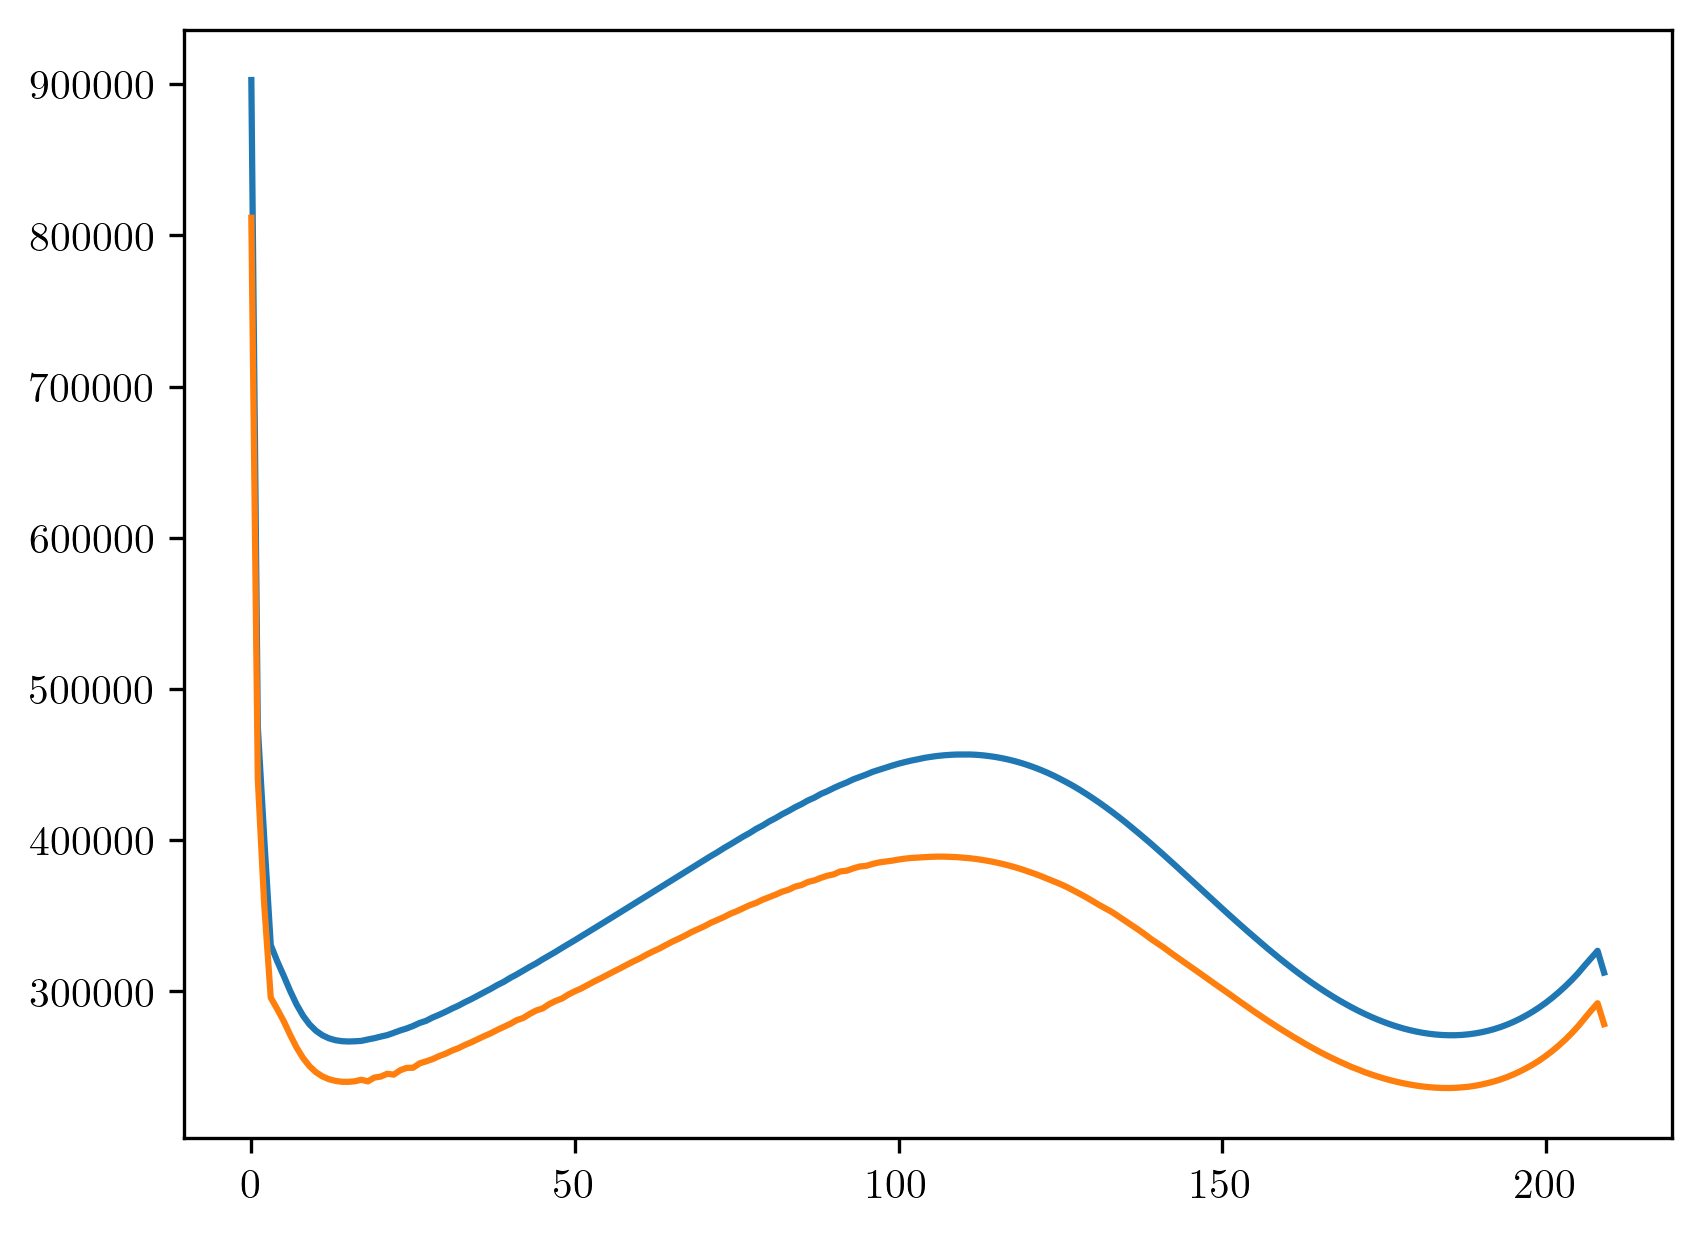

In [24]:
import matplotlib.pyplot as plt
mesh = pv.read('/home/ppiper/Dropbox/local/ihtc_repository/data/doe_30/30/SU2/outputs/cht_setupSU2.vtm')
plt.plot(mesh['Zone 0 (Comp. Fluid)']['Boundary']['UPPER_WALL']['Heat_Flux'])
plt.plot(Heat_Flux_rec)

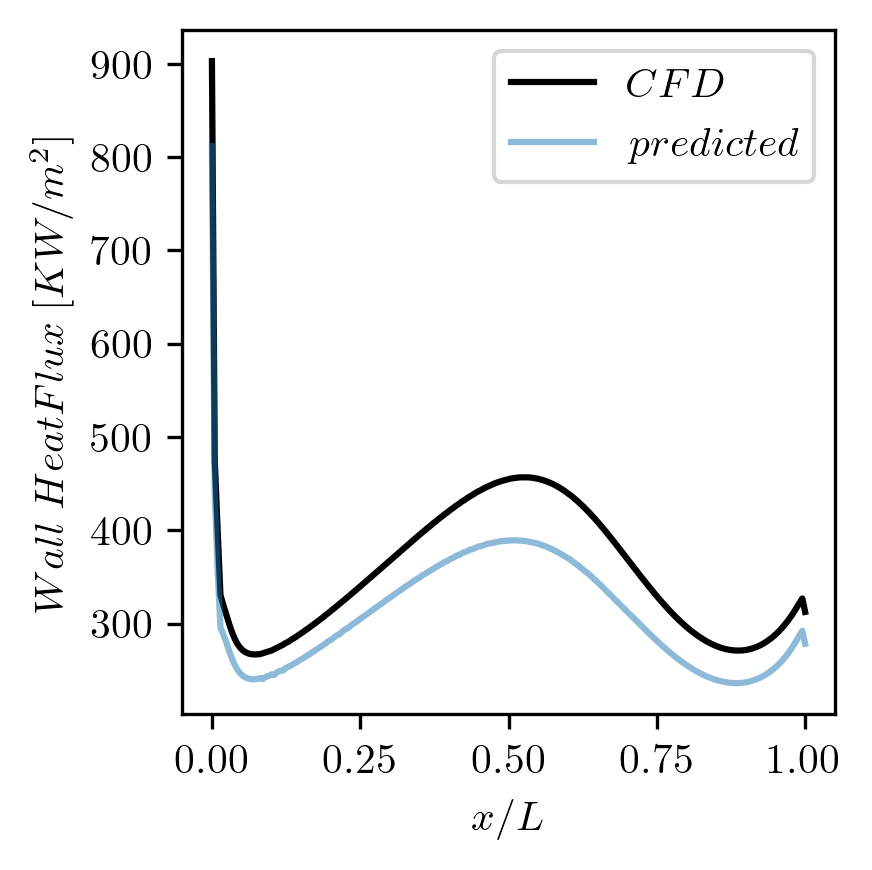

In [25]:
plt.figure(figsize=(3,3))
mesh = pv.read('/home/ppiper/Dropbox/local/ihtc_repository/data/doe_30/30/SU2/outputs/cht_setupSU2.vtm')
plt.plot(np.linspace(0,1,T_solid_rec.size),mesh['Zone 0 (Comp. Fluid)']['Boundary']['UPPER_WALL']['Heat_Flux']/1e3, label=r'$CFD$', color='k')
plt.plot(np.linspace(0,1,T_solid_rec.size),Heat_Flux_rec/1e3, label=r'$predicted$', alpha=0.5)
plt.ylabel(r'$Wall\; Heat Flux\; [KW/m^2]$')
plt.xlabel(r'$x/L$')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/predicted_wall_heat_flux.pdf')
plt.show()

In [26]:
mesh = pv.read('/home/ppiper/Dropbox/local/ihtc_repository/data/doe_30/30/SU2/outputs/cht_setupSU2.vtm')
mesh['Zone 1 (Solid Heat)']['Boundary']['INNERWALL']['Temperature']

pyvista_ndarray([369.75952, 339.77878, 353.6601 , 346.88245, 343.03946,
                 340.3109 , 338.17386, 336.456  , 335.076  , 333.97668,
                 333.1089 , 332.42828, 331.89655, 331.48187, 331.15878,
                 330.9075 , 330.71185, 330.55865, 330.45538, 330.37405,
                 330.31808, 330.2777 , 330.26947, 330.2765 , 330.28748,
                 330.31976, 330.37183, 330.41666, 330.49414, 330.56732,
                 330.65472, 330.7543 , 330.85623, 330.9751 , 331.09406,
                 331.22733, 331.36505, 331.50934, 331.66638, 331.8198 ,
                 331.99368, 332.16275, 332.34396, 332.5322 , 332.72043,
                 332.92328, 333.1271 , 333.33533, 333.55463, 333.7758 ,
                 334.00232, 334.23724, 334.47534, 334.71872, 334.96866,
                 335.22266, 335.48212, 335.7468 , 336.01624, 336.2916 ,
                 336.57056, 336.85483, 337.14545, 337.43823, 337.73648,
                 338.04178, 338.34735, 338.6591 , 338.97797, 339

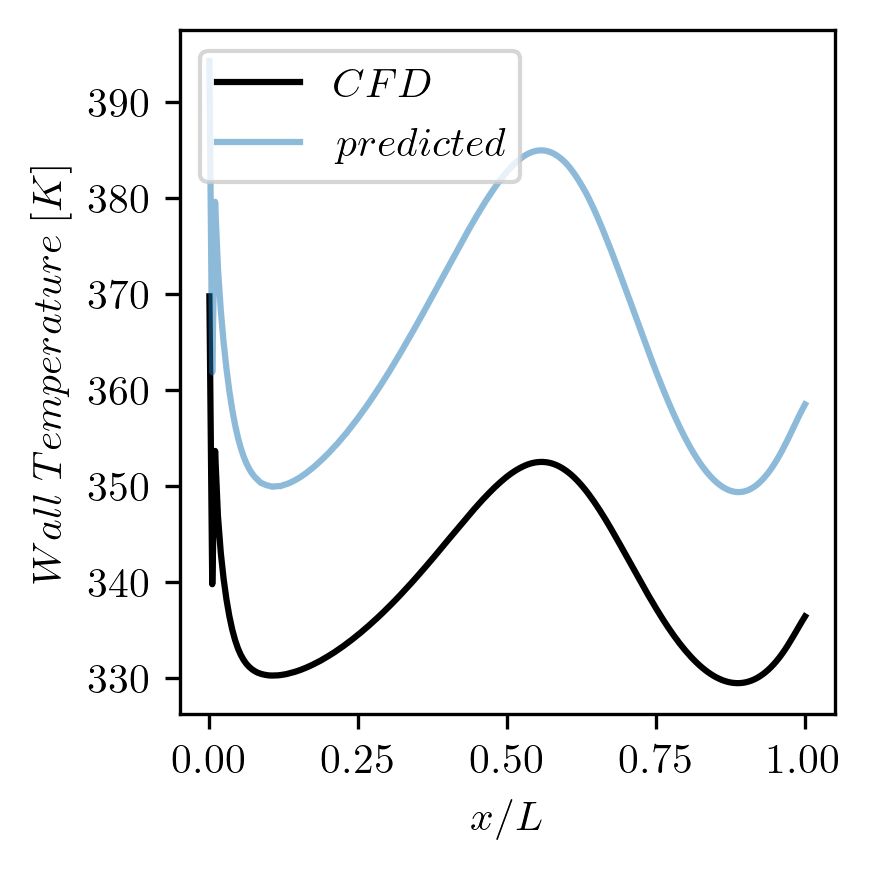

In [27]:
plt.figure(figsize=(3,3))
mesh = pv.read('/home/ppiper/Dropbox/local/ihtc_repository/data/doe_30/30/SU2/outputs/cht_setupSU2.vtm')
plt.plot(np.linspace(0,1,T_solid_rec.size),mesh['Zone 1 (Solid Heat)']['Boundary']['INNERWALL']['Temperature'], label=r'$CFD$', color='k')
plt.plot(np.linspace(0,1,T_solid_rec.size),T_solid_rec, label=r'$predicted$', alpha=0.5)
plt.ylabel(r'$Wall\; Temperature\; [K]$')
plt.xlabel(r'$x/L$')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/predicted_wall_temperature.pdf')
plt.show()

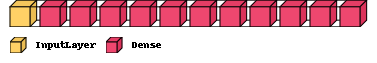

In [28]:
import visualkeras

visualkeras.layered_view(fr.surrogate.nn, legend=True)

In [29]:
def AE(x, y):
    # Mean Absolute Error 
    return (abs(x-y))

def MAE(x, y):
    # Mean Absolute Error 
    return np.mean(abs(x-y))

def MSE(x, y):
    # Mean Squared Error 
    return np.mean((x-y)**2)

def RMSE(x, y):
    # Root Mean Squared Error 
    return np.sqrt(np.mean((x-y)**2))

def NRMSE(x, y):
    # Normalized Root Mean Squared Error 
    #return np.sqrt(np.mean((x-y)**2))/np.mean(x)
    return np.sqrt(np.mean((x-y)**2))/(np.max(x)-np.min(x))    

def MAPE(x, y):
    # Mean Absolute Percentage Error 
    return np.mean(abs((x-y)/x))

def R2(x, y):
    # Coefficient of Determination
    return 1 - np.sum((x-y)**2)/np.sum((x-np.mean(y))**2)

def RSE(x, y):
    # Relative Squared Error
    return np.sum((x-y)**2)/ np.sum((x- np.mean(x))**2)

def RAE(x, y):
    # Relative Squared Error
    return np.sum((x-y)**2)/ np.sum((x- np.mean(y))**2)


In [30]:
def plot_reconstruction_var(mesh, var):
    pl = pv.Plotter()
    pv.global_theme.auto_close = True
    pl.enable_anti_aliasing('ssaa')
    pv.set_plot_theme("document")

    fluid = mesh['Zone 0 (Comp. Fluid)']['Internal']['Internal']
    if var == 'Temperature': solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
    if var == 'Temperature': solid.set_active_scalars(var)
    fluid.set_active_scalars(var)
    if var == 'Temperature':pl.add_mesh(solid)
    pl.add_mesh(fluid)

    pl.camera.tight()
    
    pl.show(screenshot=f'./figures/{var}_field_cfd.png')

    if var == 'Temperature':
        solid_rec = fr.hf_data_handler.get_variable(f'{var}_Solid',hf_reconstructed[:,2:3])
    fluid_rec = fr.hf_data_handler.get_variable(var,hf_reconstructed[:,2:3])

    if var == 'Temperature': AE_solid = AE(solid[var],solid_rec[:,0])
    AE_fluid = AE(fluid[var],fluid_rec[:,0])


    fluid[var] = fluid_rec
    if var == 'Temperature': solid[var] = solid_rec
    
    pl = pv.Plotter()
    pv.global_theme.auto_close = True
    pl.enable_anti_aliasing('ssaa')
    pv.set_plot_theme("document")

    fluid = mesh['Zone 0 (Comp. Fluid)']['Internal']['Internal']
    if var == 'Temperature': solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
    if var == 'Temperature': solid.set_active_scalars('Temperature')
    fluid.set_active_scalars(var)
    if var == 'Temperature': pl.add_mesh(solid)
    pl.add_mesh(fluid)

    pl.camera.tight()
    pl.show(screenshot=f'./figures/{var}_field_reconstructed.png')


    fluid[var] = AE_fluid
    if var == 'Temperature': solid[var] = AE_solid

    pl = pv.Plotter()
    pv.global_theme.auto_close = True
    pl.enable_anti_aliasing('ssaa')
    pv.set_plot_theme("document")

    fluid = mesh['Zone 0 (Comp. Fluid)']['Internal']['Internal']
    if var == 'Temperature': solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
    if var == 'Temperature': solid.set_active_scalars(var)
    fluid.set_active_scalars(var)
    if var == 'Temperature': pl.add_mesh(solid)
    pl.add_mesh(fluid)

    pl.camera.tight()
    pl.show(screenshot=f'./figures/{var}_field_error.png')

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


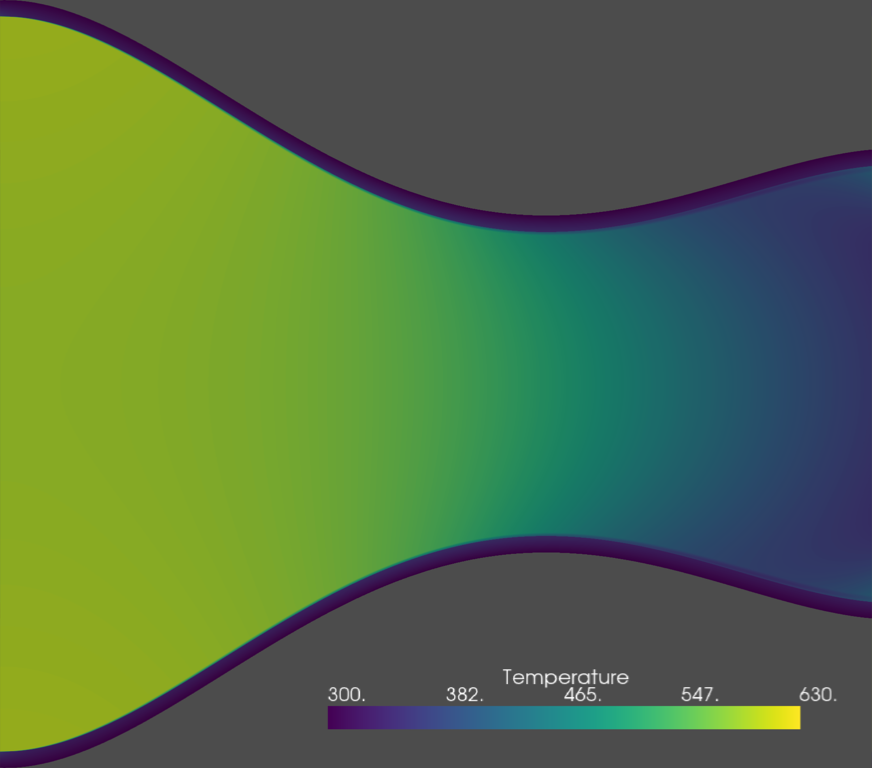

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


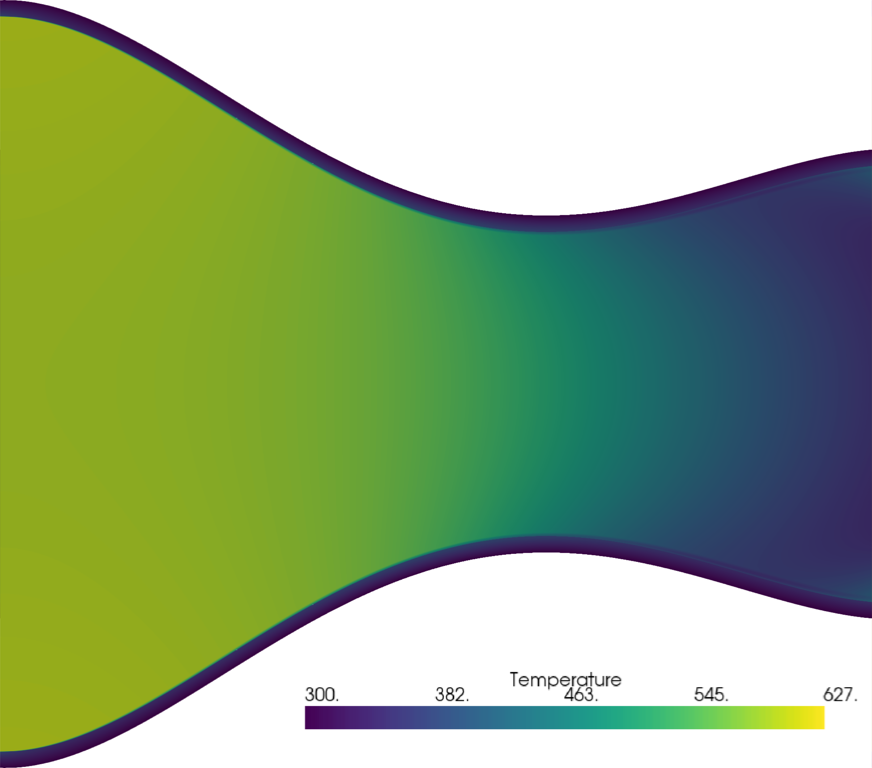

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


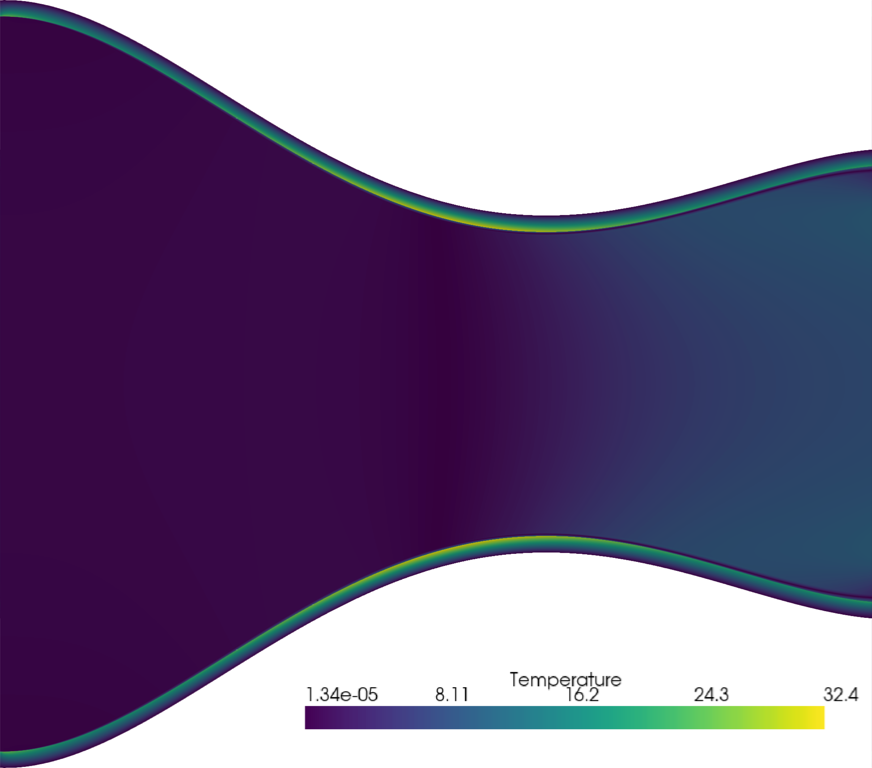

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


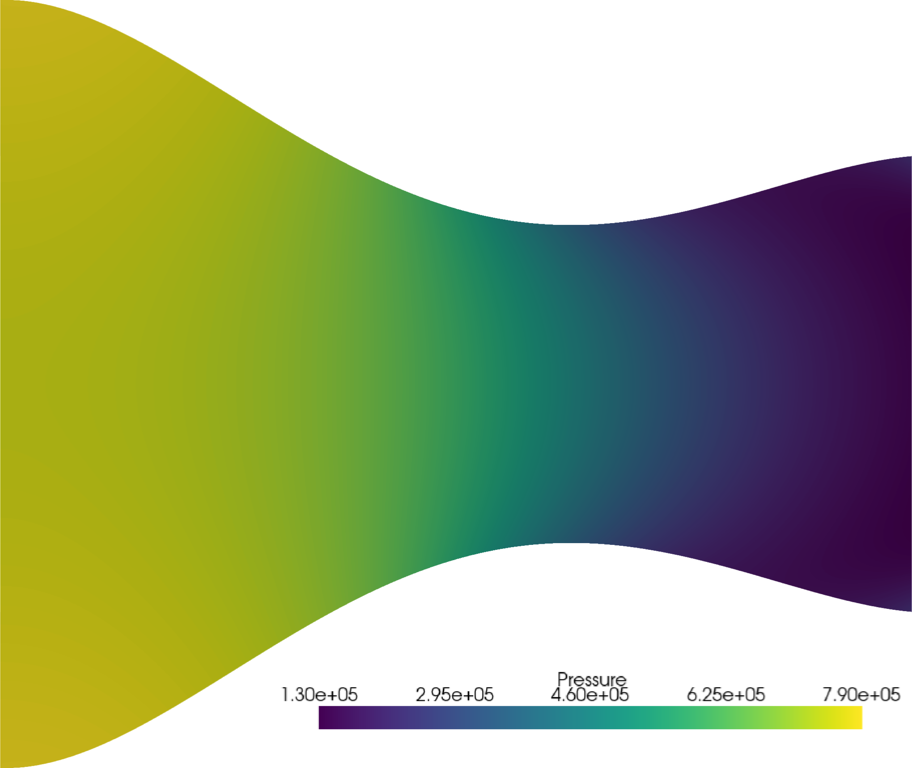

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


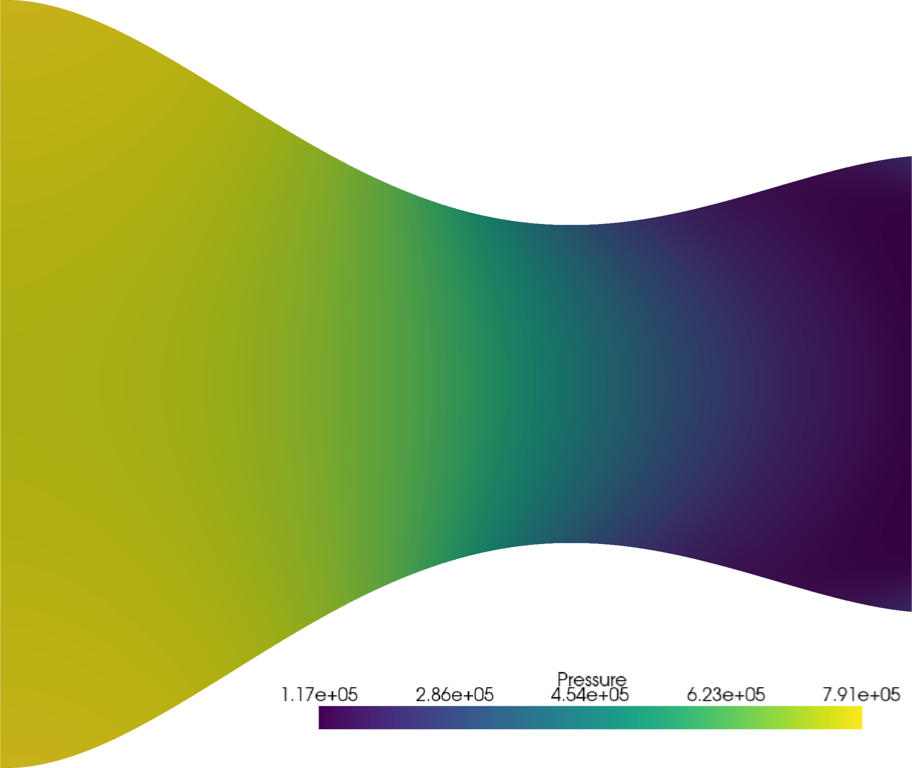

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


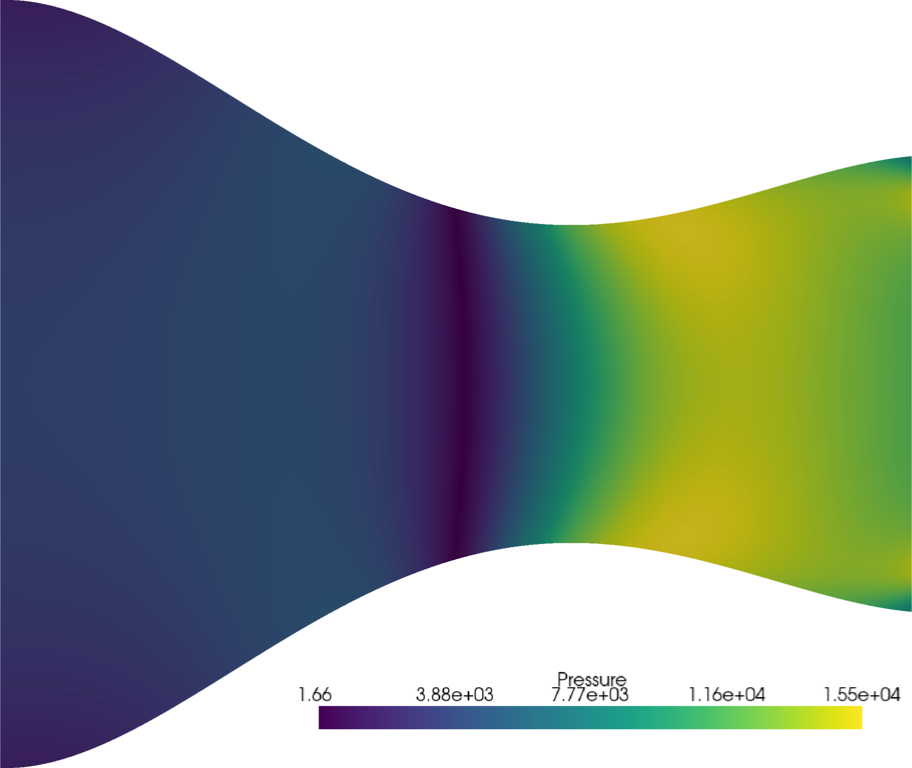

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


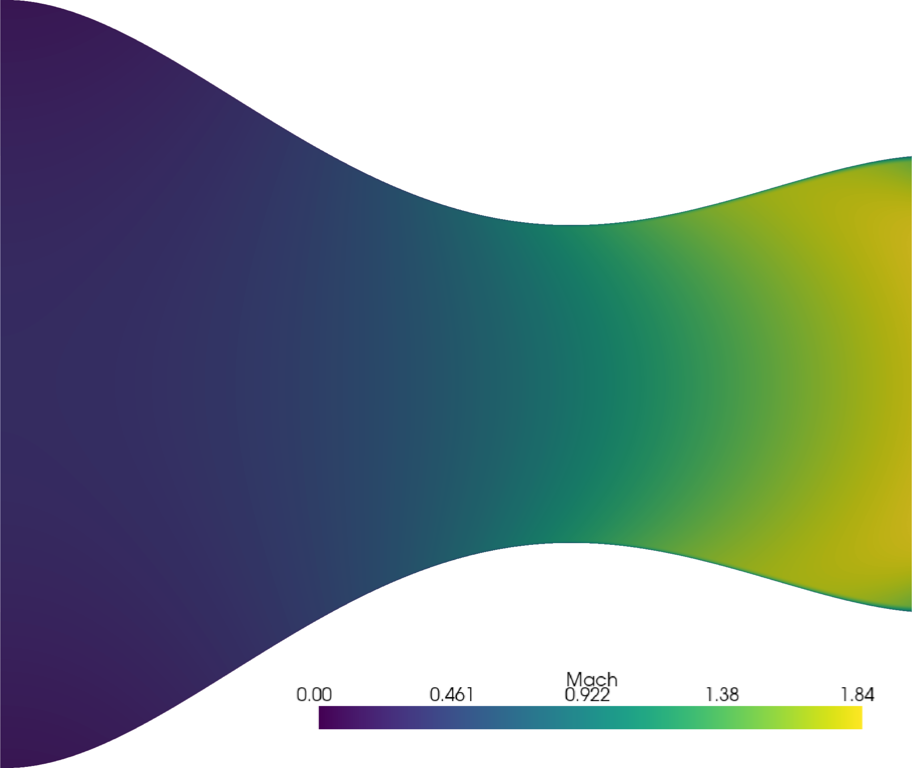

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


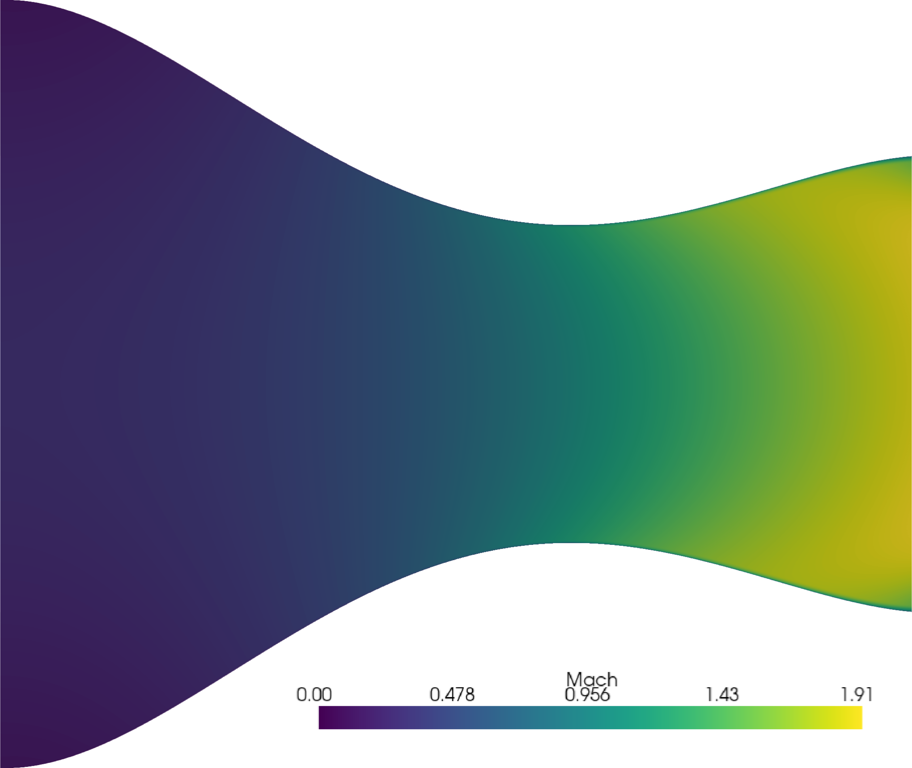

/home/ppiper/micromamba/envs/flowrec/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


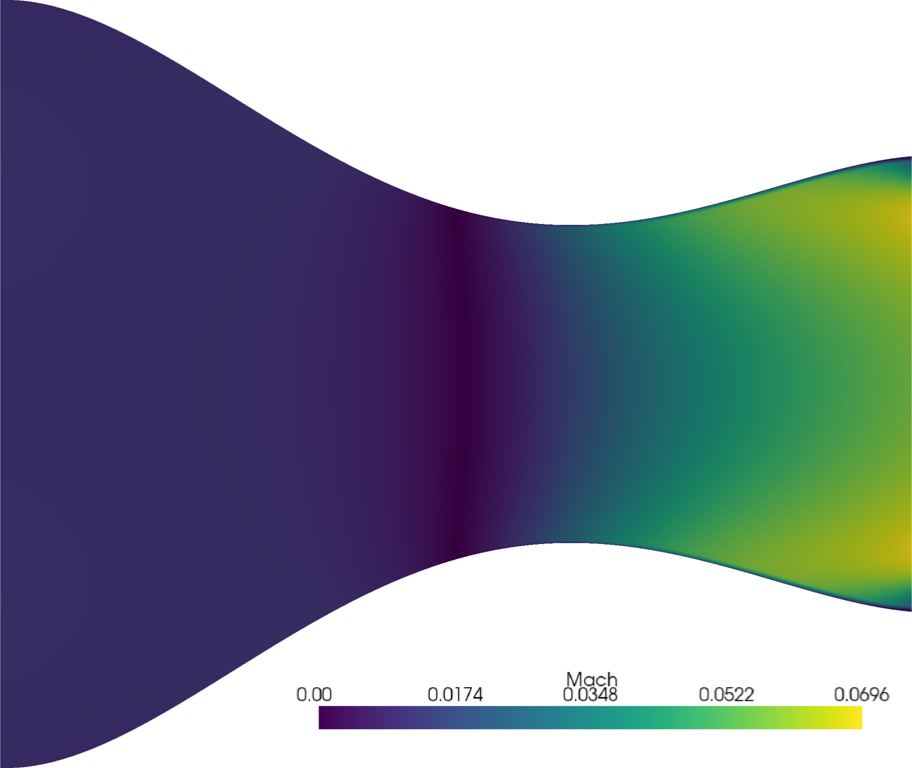

In [31]:
mesh = pv.read('/home/ppiper/Dropbox/local/ihtc_repository/data/doe_30/30/SU2/outputs/cht_setupSU2.vtm')
var = 'Pressure'

plot_reconstruction_var(mesh, 'Temperature')
plot_reconstruction_var(mesh, 'Pressure')
plot_reconstruction_var(mesh, 'Mach')

In [32]:
fluid['Temperature'] = T_fluid_rec
solid['Temperature'] = T_solid_rec

pl = pv.Plotter()
pv.global_theme.auto_close = True
pl.enable_anti_aliasing('ssaa')
pv.set_plot_theme("document")

fluid = mesh['Zone 0 (Comp. Fluid)']['Internal']['Internal']
solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
solid.set_active_scalars('Temperature')
fluid.set_active_scalars('Temperature')
pl.add_mesh(solid)
pl.add_mesh(fluid)

pl.camera.tight()
pl.show()

NameError: name 'T_fluid_rec' is not defined

In [ ]:
fluid['Temperature'].shape

In [ ]:
fluid['Temperature'] = AE_Temperature_fluid
solid['Temperature'] = AE_Temperature_solid

pl = pv.Plotter()
pv.global_theme.auto_close = True
pl.enable_anti_aliasing('ssaa')
pv.set_plot_theme("document")

fluid = mesh['Zone 0 (Comp. Fluid)']['Internal']['Internal']
solid = mesh['Zone 1 (Solid Heat)']['Internal']['Internal']
solid.set_active_scalars('Temperature')
fluid.set_active_scalars('Temperature')
pl.add_mesh(solid)
pl.add_mesh(fluid)

pl.camera.tight()
pl.show()

In [ ]:
error={}
error['MAE'] = {}
error['MSE'] = {}
error['RMSE'] = {}
error['NRMSE'] = {}
error['MAPE'] = {}
error['R2'] = {}
error['RSE'] = {}
error['RAE'] = {}
for var in fr.hf_variables_dict:

    reconstructed = fr.hf_data_handler.get_variable(variable=var,data=hf_reconstructed)
    
    original = fr.hf_data_handler.get_variable(variable=var, data=fr.hf_data_handler.test)

    #error[var] = np.linalg.norm(abs(reconstructed-original)/original, axis=0)
    
    error['MAE'][var] = MAE(original,reconstructed)
    error['MSE'][var] = MSE(original,reconstructed)
    error['NRMSE'][var] = NRMSE(original,reconstructed)
    error['RMSE'][var] = RMSE(original,reconstructed)
    error['MAPE'][var] = MAPE(original,reconstructed)
    error['R2'][var] = R2(original,reconstructed)
    error['RSE'][var] = RSE(original,reconstructed)
    error['RAE'][var] = RAE(original,reconstructed)

    
    b, a = np.polyfit(original.flatten(), reconstructed.flatten(), deg=1)

    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(original.flatten().min(), original.flatten().max(), num=100)

    # Plot regression line
    plt.figure(figsize=(3,3))
    plt.plot(xseq, a + b * xseq, color="k", label=f"R2={error['R2'][var]:.4f}")
    plt.scatter(original.flatten(), reconstructed.flatten(), alpha=0.5)
    plt.xlabel(var)
    plt.ylabel(f'predicted {var}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figures/results/{var}.png')
    plt.show()

In [ ]:
error['MAE']

In [ ]:
error['R2']

In [ ]:
#def projection_error():

# lf_train_reconstruction error
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.train)
lf_reconstructed = fr.lf_rom.reconstruct(lf_projected)
lf_original = fr.lf_data_handler.train
lf_train_reconstruction_error = NRMSE(lf_reconstructed,lf_original)

# hf_train_reconstruction error
hf_projected = fr.hf_rom.reduce(fr.hf_data_handler.train)
hf_reconstructed = fr.hf_rom.reconstruct(hf_projected)
hf_original = fr.hf_data_handler.train
hf_train_reconstruction_error = NRMSE(hf_reconstructed,hf_original)

In [ ]:
# lf_train_reconstruction error
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.validation)
lf_reconstructed = fr.lf_rom.reconstruct(lf_projected)
lf_original = fr.lf_data_handler.validation
lf_validation_reconstruction_error = NRMSE(lf_reconstructed,lf_original)

# hf_train_reconstruction error
hf_projected = fr.hf_rom.reduce(fr.hf_data_handler.validation)
hf_reconstructed = fr.hf_rom.reconstruct(hf_projected)
hf_original = fr.hf_data_handler.validation
hf_validation_reconstruction_error = NRMSE(hf_reconstructed,hf_original)

In [ ]:
# lf_train_reconstruction error
lf_projected = fr.lf_rom.reduce(fr.lf_data_handler.test)
lf_reconstructed = fr.lf_rom.reconstruct(lf_projected)
lf_original = fr.lf_data_handler.test
lf_test_reconstruction_error = NRMSE(lf_reconstructed,lf_original)

# hf_train_reconstruction error
hf_projected = fr.hf_rom.reduce(fr.hf_data_handler.test)
hf_reconstructed = fr.hf_rom.reconstruct(hf_projected)
hf_original = fr.hf_data_handler.test
hf_test_reconstruction_error = NRMSE(hf_reconstructed,hf_original)

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))

lf_svd_energy = np.loadtxt('./figures/lf_svd_energy.txt',  delimiter=',')
hf_svd_energy= np.loadtxt('./figures/hf_svd_energy.txr',   delimiter=',')


ax.plot(lf_svd_energy, label=r"$Low\; Fidelity$", c='k',alpha=0.5)
ax.plot(hf_svd_energy, label=r"$High\; Fidelity$", c='blue',alpha=0.5)
plt.xlabel(r"$k-th\; mode$")
plt.ylabel(r"$\% Energy$")

plt.legend()
plt.show()
plt.savefig('./figures/svd_energy.pdf')

In [ ]:
!pip install keras-visualizer

In [ ]:
from keras_visualizer import visualizer

visualizer(model=fr.surrogate.nn, file_name='./figures/nn.pdf',file_format='pdf',view=True)

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(fr.surrogate.nn, to_file='./figures/keras.pdf', show_shapes=True, show_layer_names=True)

In [16]:
90*60/10.6

509.433962264151

In [ ]:
Sure, here are some relevant references for SVD, POD, flow reconstruction, and neural networks in the context of fluid dynamics:

- Golub, G. H., and C. F. Van Loan. Matrix Computations. 4th ed., Johns Hopkins University Press, 2013. (Reference for SVD)

- Lumley, J. L. "The Structure of Inhomogeneous Turbulent Flows." Atmospheric Turbulence and Radio Wave Propagation, edited by J. L. Lumley, vol. 2, Springer-Verlag, 1967, pp. 166-178. (Reference for POD)

- Iliescu, T., and J. M. Nordbotten. "Reduced-Order Modeling of Flow Problems." Annual Review of Fluid Mechanics, vol. 52, no. 1, 2020, pp. 455-484. (Reference for flow reconstruction)

- Liao, W., et al. "Reduced-Order Modeling of Turbulent Flow in a Combustion Chamber with Deep Neural Networks." Combustion Theory and Modelling, vol. 24, no. 4, 2020, pp. 632-652. (Reference for neural networks in fluid dynamics)

- Brunton, S. L., and J. N. Kutz. Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control. Cambridge University Press, 2019. (Reference for neural networks in general)